# Embeddings Analysis

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import distinctipy
from datasets import load_dataset
from cuml import TSNE

from ettcl.encoding import ColBERTEncoder

seaborn.set_theme(style="dark")

dataset_name = "imdb"
text_column = "text"
label_column = "label"

In [2]:
train_dataset = load_dataset(dataset_name, split="train")
train_dataset = train_dataset.rename_columns({text_column: "text", label_column: "label"})
train_dataset = train_dataset.train_test_split(train_size=50, stratify_by_column="label")["train"]
train_dataset.set_format("numpy")
train_dataset

Found cached dataset imdb (/home/IAIS/hiser/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


Dataset({
    features: ['text', 'label'],
    num_rows: 50
})

## bert-base-uncased (official pretrained model)

In [3]:
checkpoint = "bert-base-uncased"
encoder = ColBERTEncoder.from_pretrained(checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing ColBERTModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing ColBERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ColBERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
encoder.cuda()
embs, doc_lens = encoder.encode_passages(train_dataset["text"])
encoder.cpu()
doc_lens = np.array(doc_lens)
embs = embs.numpy()

labels = np.concatenate([np.full(doc_len, label) for label, doc_len in zip(train_dataset["label"], doc_lens)])
doc_ids = np.concatenate([np.full(doc_len, i) for i, doc_len in enumerate(doc_lens)])

print("embs", embs.shape)
print("labels", labels.shape)
print("doc_ids", doc_ids.shape)

Encoding:   0%|          | 0/1 [00:00<?, ?it/s]

embs (12978, 768)
labels (12978,)
doc_ids (12978,)


In [5]:
vecs = TSNE(
    n_components=2,
    learning_rate=200,
    perplexity=5,
    n_neighbors=25,
).fit_transform(embs)

/home/IAIS/hiser/miniconda3/envs/colbert/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


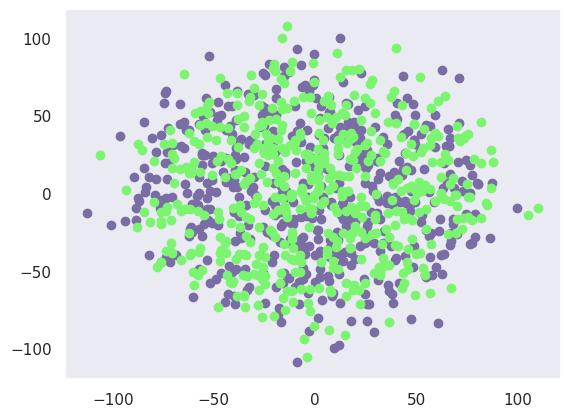

In [6]:
colors = distinctipy.get_colors(len(np.unique(labels)), pastel_factor=0.7)

for i, label in enumerate(np.unique(labels)):
    vecs_ = vecs[labels == label]
    indices = np.random.choice(vecs_.shape[0], size=500, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i]);

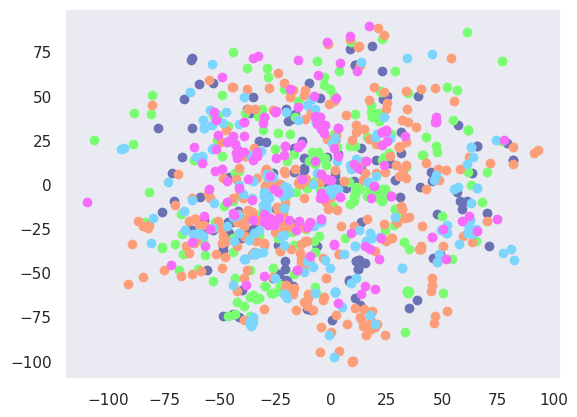

In [7]:
# N = len(train_dataset)
N = 5
colors = distinctipy.get_colors(N, pastel_factor=0.7)

for i in range(N):
    vecs_ = vecs[doc_ids == i]
    plt.scatter(*vecs_.T, color=colors[i]);

## bert-base-uncased (finetuned on imdb)

In [8]:
checkpoint = "training/imdb/bert-base-uncased/2023-06-30T09:30:28.027860/checkpoint-7500"
encoder = ColBERTEncoder.from_pretrained(checkpoint)

In [9]:
encoder.cuda()
embs, doc_lens = encoder.encode_passages(train_dataset["text"])
encoder.cpu()
doc_lens = np.array(doc_lens)
embs = embs.numpy()

labels = np.concatenate([np.full(doc_len, label) for label, doc_len in zip(train_dataset["label"], doc_lens)])
doc_ids = np.concatenate([np.full(doc_len, i) for i, doc_len in enumerate(doc_lens)])

print("embs", embs.shape)
print("labels", labels.shape)
print("doc_ids", doc_ids.shape)

Encoding:   0%|          | 0/1 [00:00<?, ?it/s]

embs (12978, 128)
labels (12978,)
doc_ids (12978,)


In [10]:
vecs = TSNE(
    n_components=2,
    learning_rate=200,
    perplexity=5,
    n_neighbors=25,
).fit_transform(embs)

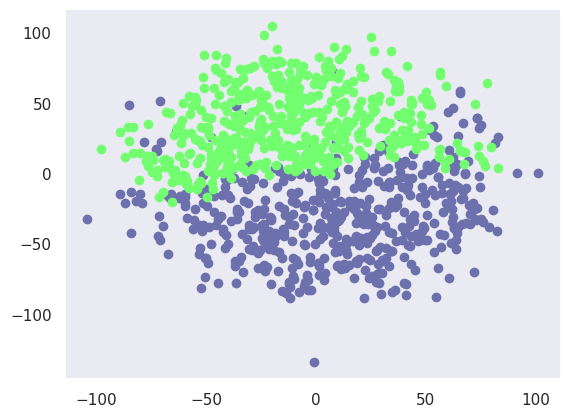

In [11]:
colors = distinctipy.get_colors(len(np.unique(labels)), pastel_factor=0.7)

for i, label in enumerate(np.unique(labels)):
    vecs_ = vecs[labels == label]
    indices = np.random.choice(vecs_.shape[0], size=500, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i]);

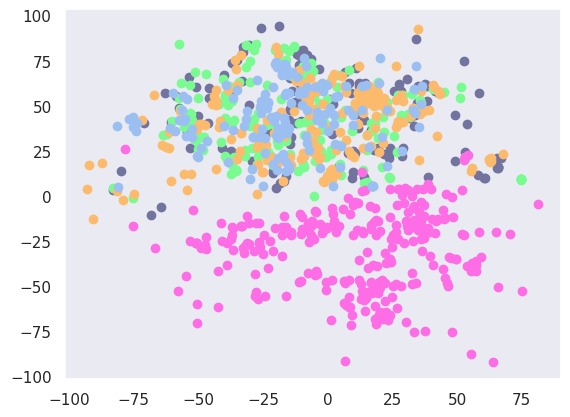

In [12]:
# N = len(train_dataset)
N = 5
colors = distinctipy.get_colors(N, pastel_factor=0.7)

for i in range(N):
    vecs_ = vecs[doc_ids == i]
    plt.scatter(*vecs_.T, color=colors[i]);